In [1]:
# Movie Recommendation System - MovieLens 100K Dataset
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print("Building a collaborative filtering movie recommendation system using MovieLens 100K dataset")

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.sparse import csr_matrix, issparse


Libraries imported successfully!
Building a collaborative filtering movie recommendation system using MovieLens 100K dataset


In [2]:
# Load the datasets
# Ratings data: user_id, movie_id, rating, timestamp
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Movies data: movie_id, title, release_date, video_release_date, imdb_url, genres
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', 
                     names=['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url'] + 
                           [f'genre_{i}' for i in range(19)])

# Users data: user_id, age, gender, occupation, zip_code
users = pd.read_csv('ml-100k/u.user', sep='|', 
                    names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

print("Dataset loaded successfully!")
print(f"Ratings dataset shape: {ratings.shape}")
print(f"Movies dataset shape: {movies.shape}")
print(f"Users dataset shape: {users.shape}")
print("\nFirst few ratings:")
print(ratings.head())

Dataset loaded successfully!
Ratings dataset shape: (100000, 4)
Movies dataset shape: (1682, 24)
Users dataset shape: (943, 5)

First few ratings:
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596


Dataset Statistics:
Number of users: 943
Number of movies: 1682
Number of ratings: 100000
Rating scale: 1 to 5
Average rating: 3.53

Rating distribution:
rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64

Sample movies:
   movie_id                                              title
0         1                                   Toy Story (1995)
1         2                                   GoldenEye (1995)
2         3                                  Four Rooms (1995)
3         4                                  Get Shorty (1995)
4         5                                     Copycat (1995)
5         6  Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6         7                              Twelve Monkeys (1995)
7         8                                        Babe (1995)
8         9                            Dead Man Walking (1995)
9        10                                 Richard III (1995)

Data sparsity: 93.70% (most user-movie pairs hav

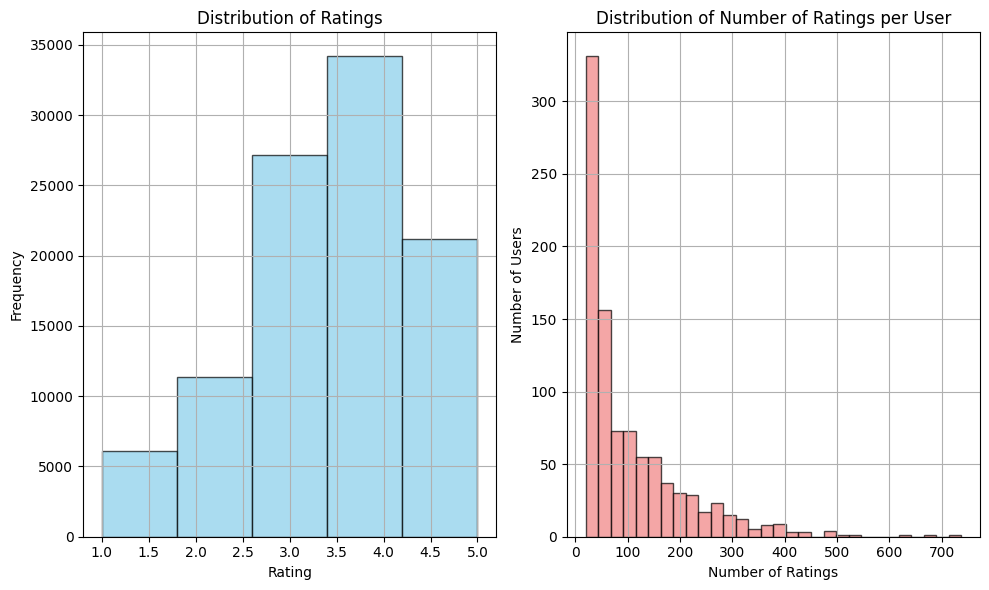

In [3]:
# Data exploration
print("Dataset Statistics:")
print("="*50)
print(f"Number of users: {ratings['user_id'].nunique()}")
print(f"Number of movies: {ratings['movie_id'].nunique()}")
print(f"Number of ratings: {len(ratings)}")
print(f"Rating scale: {ratings['rating'].min()} to {ratings['rating'].max()}")
print(f"Average rating: {ratings['rating'].mean():.2f}")

print("\nRating distribution:")
print(ratings['rating'].value_counts().sort_index())

# Display some movie titles
print("\nSample movies:")
print(movies[['movie_id', 'title']].head(10))

# Basic statistics about the sparsity
total_possible_ratings = ratings['user_id'].nunique() * ratings['movie_id'].nunique()
sparsity = (1 - len(ratings) / total_possible_ratings) * 100
print(f"\nData sparsity: {sparsity:.2f}% (most user-movie pairs have no rating)")

# Visualize rating distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
ratings['rating'].hist(bins=5, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
user_rating_counts = ratings.groupby('user_id').size()
user_rating_counts.hist(bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')

plt.tight_layout()
plt.show()

In [4]:
# Create user-item matrix
print("Creating user-item matrix...")

# Create a pivot table with users as rows and movies as columns
user_item_matrix = ratings.pivot_table(index='user_id', columns='movie_id', values='rating')

print(f"User-item matrix shape: {user_item_matrix.shape}")
print(f"Matrix sparsity: {user_item_matrix.isnull().sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100:.2f}%")

# Fill NaN values with 0 (no rating)
user_item_matrix_filled = user_item_matrix.fillna(0)

# Display a small portion of the matrix
print("\nSample of user-item matrix (first 5 users, first 5 movies):")
print(user_item_matrix_filled.iloc[:5, :5])

# Convert to numpy array for faster computation
user_item_np = user_item_matrix_filled.values

print(f"\nUser-item matrix converted to numpy array with shape: {user_item_np.shape}")

Creating user-item matrix...
User-item matrix shape: (943, 1682)
Matrix sparsity: 93.70%

Sample of user-item matrix (first 5 users, first 5 movies):
movie_id    1    2    3    4    5
user_id                          
1         5.0  3.0  4.0  3.0  3.0
2         4.0  0.0  0.0  0.0  0.0
3         0.0  0.0  0.0  0.0  0.0
4         0.0  0.0  0.0  0.0  0.0
5         4.0  3.0  0.0  0.0  0.0

User-item matrix converted to numpy array with shape: (943, 1682)


In [5]:
# Implement User-Based Collaborative Filtering
class UserBasedCollaborativeFiltering:
    def __init__(self, user_item_matrix):
        self.user_item_matrix = user_item_matrix
        self.user_similarity_matrix = None
        
    def compute_user_similarity(self):
        """Compute cosine similarity between users"""
        print("Computing user similarity matrix...")
        
        # Compute cosine similarity between users
        # Note: We use the filled matrix where 0 means no rating
        self.user_similarity_matrix = cosine_similarity(self.user_item_matrix)
        
        print(f"User similarity matrix shape: {self.user_similarity_matrix.shape}")
        return self.user_similarity_matrix
    
    def get_similar_users(self, user_id, n_similar=10):
        """Get most similar users to a given user"""
        if self.user_similarity_matrix is None:
            self.compute_user_similarity()
            
        # Convert user_id to index (user_id starts from 1, index starts from 0)
        user_idx = user_id - 1
        
        # Get similarity scores for the user
        user_similarities = self.user_similarity_matrix[user_idx]
        
        # Get indices of most similar users (excluding the user itself)
        similar_user_indices = np.argsort(user_similarities)[::-1][1:n_similar+1]
        
        # Convert back to user_ids and get similarity scores
        similar_users = [(idx + 1, user_similarities[idx]) for idx in similar_user_indices]
        
        return similar_users
    
    def predict_rating(self, user_id, movie_id, n_similar=10):
        """Predict rating for a user-movie pair"""
        if self.user_similarity_matrix is None:
            self.compute_user_similarity()
            
        user_idx = user_id - 1
        movie_idx = movie_id - 1
        
        # Get similar users
        similar_users = self.get_similar_users(user_id, n_similar)
        
        # Calculate weighted average rating
        weighted_sum = 0
        similarity_sum = 0
        
        for similar_user_id, similarity in similar_users:
            similar_user_idx = similar_user_id - 1
            rating = self.user_item_matrix[similar_user_idx, movie_idx]
            
            if rating > 0:  # Only consider users who have rated this movie
                weighted_sum += similarity * rating
                similarity_sum += abs(similarity)
        
        if similarity_sum == 0:
            # If no similar users have rated this movie, return average rating
            return np.mean(self.user_item_matrix[self.user_item_matrix > 0])
        
        predicted_rating = weighted_sum / similarity_sum
        return predicted_rating
    
    def recommend_movies(self, user_id, n_recommendations=10, n_similar=10):
        """Recommend movies for a user"""
        user_idx = user_id - 1
        
        # Get movies the user hasn't rated
        user_ratings = self.user_item_matrix[user_idx]
        unrated_movies = np.where(user_ratings == 0)[0]
        
        # Predict ratings for unrated movies
        movie_predictions = []
        for movie_idx in unrated_movies:
            movie_id = movie_idx + 1
            predicted_rating = self.predict_rating(user_id, movie_id, n_similar)
            movie_predictions.append((movie_id, predicted_rating))
        
        # Sort by predicted rating and return top N
        movie_predictions.sort(key=lambda x: x[1], reverse=True)
        return movie_predictions[:n_recommendations]

# Initialize the recommendation system
print("Initializing User-Based Collaborative Filtering...")
recommender = UserBasedCollaborativeFiltering(user_item_np)

# Compute user similarities
user_similarities = recommender.compute_user_similarity()

print("User-based collaborative filtering system initialized successfully!")

Initializing User-Based Collaborative Filtering...
Computing user similarity matrix...
User similarity matrix shape: (943, 943)
User-based collaborative filtering system initialized successfully!


In [6]:
# Test the recommendation system
def display_recommendations(user_id, n_recommendations=10):
    """Display movie recommendations for a user"""
    print(f"\n{'='*60}")
    print(f"MOVIE RECOMMENDATIONS FOR USER {user_id}")
    print(f"{'='*60}")
    
    # Get user's existing ratings
    user_ratings = ratings[ratings['user_id'] == user_id].merge(movies[['movie_id', 'title']], on='movie_id')
    user_ratings = user_ratings.sort_values('rating', ascending=False)
    
    print(f"User {user_id} has rated {len(user_ratings)} movies.")
    print(f"\nTop 5 highest rated movies by this user:")
    for _, row in user_ratings.head().iterrows():
        print(f"  • {row['title']} - Rating: {row['rating']}")
    
    # Get similar users
    similar_users = recommender.get_similar_users(user_id, n_similar=5)
    print(f"\nTop 5 most similar users:")
    for similar_user_id, similarity in similar_users:
        print(f"  • User {similar_user_id} (Similarity: {similarity:.3f})")
    
    # Get movie recommendations
    recommendations = recommender.recommend_movies(user_id, n_recommendations)
    
    print(f"\nTop {n_recommendations} movie recommendations:")
    for i, (movie_id, predicted_rating) in enumerate(recommendations, 1):
        movie_title = movies[movies['movie_id'] == movie_id]['title'].iloc[0]
        print(f"  {i:2d}. {movie_title} (Predicted Rating: {predicted_rating:.2f})")

# Test with a few users
test_users = [1, 50, 100, 200]

for user_id in test_users:
    display_recommendations(user_id, n_recommendations=8)


MOVIE RECOMMENDATIONS FOR USER 1
User 1 has rated 272 movies.

Top 5 highest rated movies by this user:
  • Back to the Future (1985) - Rating: 5
  • When Harry Met Sally... (1989) - Rating: 5
  • Nikita (La Femme Nikita) (1990) - Rating: 5
  • Three Colors: Blue (1993) - Rating: 5
  • Lone Star (1996) - Rating: 5

Top 5 most similar users:
  • User 916 (Similarity: 0.569)
  • User 864 (Similarity: 0.548)
  • User 268 (Similarity: 0.542)
  • User 92 (Similarity: 0.541)
  • User 435 (Similarity: 0.539)

Top 8 movie recommendations:
   1. Casablanca (1942) (Predicted Rating: 5.00)
   2. Secrets & Lies (1996) (Predicted Rating: 5.00)
   3. Wings of Desire (1987) (Predicted Rating: 5.00)
   4. Walk in the Clouds, A (1995) (Predicted Rating: 5.00)
   5. American in Paris, An (1951) (Predicted Rating: 5.00)
   6. Sophie's Choice (1982) (Predicted Rating: 5.00)
   7. Shadowlands (1993) (Predicted Rating: 5.00)
   8. Braindead (1992) (Predicted Rating: 5.00)

MOVIE RECOMMENDATIONS FOR USER 50

In [7]:
# Evaluation: Precision at K
def evaluate_precision_at_k(test_data, k_values=[5, 10, 15, 20], rating_threshold=4.0):
    """
    Evaluate the recommendation system using Precision@K
    
    Args:
        test_data: DataFrame with columns ['user_id', 'movie_id', 'rating']
        k_values: List of K values to evaluate
        rating_threshold: Minimum rating to consider as "relevant"
    
    Returns:
        Dictionary with precision@k for each k value
    """
    print("Evaluating Precision@K...")
    print(f"Using rating threshold: {rating_threshold}")
    print(f"Evaluating for K values: {k_values}")
    
    precision_results = {k: [] for k in k_values}
    
    # Get unique users in test data
    test_users = test_data['user_id'].unique()
    print(f"Evaluating on {len(test_users)} users...")
    
    for i, user_id in enumerate(test_users[:100]):  # Limit to first 100 users for faster evaluation
        if (i + 1) % 20 == 0:
            print(f"  Processed {i+1} users...")
            
        # Get user's test ratings
        user_test = test_data[test_data['user_id'] == user_id]
        
        # Get relevant items (high-rated movies in test set)
        relevant_items = set(user_test[user_test['rating'] >= rating_threshold]['movie_id'])
        
        if len(relevant_items) == 0:
            continue  # Skip users with no relevant items
        
        try:
            # Get recommendations for this user
            recommendations = recommender.recommend_movies(user_id, n_recommendations=max(k_values))
            recommended_items = [movie_id for movie_id, _ in recommendations]
            
            # Calculate precision@k for each k
            for k in k_values:
                if len(recommended_items) >= k:
                    top_k_recommendations = set(recommended_items[:k])
                    relevant_and_recommended = top_k_recommendations.intersection(relevant_items)
                    precision_k = len(relevant_and_recommended) / k
                    precision_results[k].append(precision_k)
                    
        except Exception as e:
            print(f"Error processing user {user_id}: {e}")
            continue
    
    # Calculate average precision@k
    avg_precision = {}
    for k in k_values:
        if precision_results[k]:
            avg_precision[k] = np.mean(precision_results[k])
            print(f"Precision@{k}: {avg_precision[k]:.4f} (based on {len(precision_results[k])} users)")
        else:
            avg_precision[k] = 0.0
            print(f"Precision@{k}: No valid results")
    
    return avg_precision

# Split data for evaluation
print("Splitting data for evaluation...")
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42, stratify=ratings['user_id'])

print(f"Training data: {len(train_data)} ratings")
print(f"Test data: {len(test_data)} ratings")

# Create training user-item matrix for fair evaluation
train_user_item = train_data.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)

# Ensure the matrix has the same shape as the original
# Reindex to include all users and movies
all_users = sorted(ratings['user_id'].unique())
all_movies = sorted(ratings['movie_id'].unique())
train_user_item = train_user_item.reindex(index=all_users, columns=all_movies, fill_value=0)

print(f"Training user-item matrix shape: {train_user_item.shape}")

# Initialize recommender with training data
train_recommender = UserBasedCollaborativeFiltering(train_user_item.values)
train_recommender.compute_user_similarity()

# Temporarily replace the global recommender for evaluation
original_recommender = recommender
recommender = train_recommender

# Evaluate the system
precision_scores = evaluate_precision_at_k(test_data)

# Restore original recommender
recommender = original_recommender

Splitting data for evaluation...
Training data: 80000 ratings
Test data: 20000 ratings
Training user-item matrix shape: (943, 1682)
Computing user similarity matrix...
User similarity matrix shape: (943, 943)
Evaluating Precision@K...
Using rating threshold: 4.0
Evaluating for K values: [5, 10, 15, 20]
Evaluating on 943 users...
  Processed 20 users...
  Processed 40 users...
  Processed 60 users...
  Processed 80 users...
  Processed 100 users...
Precision@5: 0.0240 (based on 100 users)
Precision@10: 0.0240 (based on 100 users)
Precision@15: 0.0287 (based on 100 users)
Precision@20: 0.0355 (based on 100 users)


In [8]:
# Bonus: Item-Based Collaborative Filtering
class ItemBasedCollaborativeFiltering:
    def __init__(self, user_item_matrix):
        self.user_item_matrix = user_item_matrix.T  # Transpose to get item-user matrix
        self.item_similarity_matrix = None
        
    def compute_item_similarity(self):
        """Compute cosine similarity between items"""
        print("Computing item similarity matrix...")
        self.item_similarity_matrix = cosine_similarity(self.user_item_matrix)
        print(f"Item similarity matrix shape: {self.item_similarity_matrix.shape}")
        return self.item_similarity_matrix
    
    def recommend_movies(self, user_id, n_recommendations=10, n_similar=10):
        """Recommend movies based on item similarity"""
        if self.item_similarity_matrix is None:
            self.compute_item_similarity()
            
        user_idx = user_id - 1
        user_ratings = user_item_np[user_idx]  # Get user's ratings
        
        # Get movies the user hasn't rated
        unrated_movies = np.where(user_ratings == 0)[0]
        
        # Predict ratings for unrated movies
        movie_predictions = []
        
        for movie_idx in unrated_movies:
            # Get similarity scores for this movie with all other movies
            movie_similarities = self.item_similarity_matrix[movie_idx]
            
            # Get movies that the user has rated
            rated_movies = np.where(user_ratings > 0)[0]
            
            # Calculate weighted average based on item similarities
            weighted_sum = 0
            similarity_sum = 0
            
            for rated_movie_idx in rated_movies:
                similarity = movie_similarities[rated_movie_idx]
                rating = user_ratings[rated_movie_idx]
                
                if similarity > 0:  # Only consider positively correlated items
                    weighted_sum += similarity * rating
                    similarity_sum += abs(similarity)
            
            if similarity_sum > 0:
                predicted_rating = weighted_sum / similarity_sum
                movie_predictions.append((movie_idx + 1, predicted_rating))
        
        # Sort by predicted rating and return top N
        movie_predictions.sort(key=lambda x: x[1], reverse=True)
        return movie_predictions[:n_recommendations]

# Initialize item-based collaborative filtering
print("Initializing Item-Based Collaborative Filtering...")
item_recommender = ItemBasedCollaborativeFiltering(user_item_np)
item_recommender.compute_item_similarity()

print("Item-based collaborative filtering system initialized successfully!")

Initializing Item-Based Collaborative Filtering...
Computing item similarity matrix...
Item similarity matrix shape: (1682, 1682)
Item-based collaborative filtering system initialized successfully!


In [9]:
# Bonus: Matrix Factorization (SVD)
from sklearn.decomposition import TruncatedSVD

class SVDRecommender:
    def __init__(self, user_item_matrix, n_components=50):
        self.user_item_matrix = user_item_matrix
        self.n_components = n_components
        self.svd = None
        self.user_factors = None
        self.item_factors = None
        
    def fit(self):
        """Fit SVD model"""
        print(f"Fitting SVD with {self.n_components} components...")
        
        # Apply SVD
        self.svd = TruncatedSVD(n_components=self.n_components, random_state=42)
        self.user_factors = self.svd.fit_transform(self.user_item_matrix)
        self.item_factors = self.svd.components_
        
        print(f"SVD fitted successfully!")
        print(f"User factors shape: {self.user_factors.shape}")
        print(f"Item factors shape: {self.item_factors.shape}")
        
        return self
    
    def predict_rating(self, user_id, movie_id):
        """Predict rating for a user-movie pair"""
        user_idx = user_id - 1
        movie_idx = movie_id - 1
        
        # Dot product of user and item factors
        predicted_rating = np.dot(self.user_factors[user_idx], self.item_factors[:, movie_idx])
        
        # Clip to rating scale [1, 5]
        return np.clip(predicted_rating, 1, 5)
    
    def recommend_movies(self, user_id, n_recommendations=10):
        """Recommend movies for a user"""
        user_idx = user_id - 1
        
        # Get movies the user hasn't rated
        user_ratings = self.user_item_matrix[user_idx]
        unrated_movies = np.where(user_ratings == 0)[0]
        
        # Predict ratings for unrated movies
        movie_predictions = []
        for movie_idx in unrated_movies:
            movie_id = movie_idx + 1
            predicted_rating = self.predict_rating(user_id, movie_id)
            movie_predictions.append((movie_id, predicted_rating))
        
        # Sort by predicted rating and return top N
        movie_predictions.sort(key=lambda x: x[1], reverse=True)
        return movie_predictions[:n_recommendations]

# Initialize and fit SVD recommender
print("Initializing Matrix Factorization (SVD) Recommender...")
svd_recommender = SVDRecommender(user_item_np, n_components=50)
svd_recommender.fit()

print("SVD recommender initialized successfully!")

Initializing Matrix Factorization (SVD) Recommender...
Fitting SVD with 50 components...
SVD fitted successfully!
User factors shape: (943, 50)
Item factors shape: (50, 1682)
SVD recommender initialized successfully!


In [10]:
# Compare all recommendation approaches
def compare_recommendations(user_id, n_recommendations=5):
    """Compare recommendations from all three approaches"""
    print(f"\n{'='*80}")
    print(f"RECOMMENDATION COMPARISON FOR USER {user_id}")
    print(f"{'='*80}")
    
    # Get user's existing ratings
    user_ratings = ratings[ratings['user_id'] == user_id].merge(movies[['movie_id', 'title']], on='movie_id')
    user_ratings = user_ratings.sort_values('rating', ascending=False)
    
    print(f"User {user_id} has rated {len(user_ratings)} movies.")
    print(f"Average rating by this user: {user_ratings['rating'].mean():.2f}")
    
    print(f"\nTop 3 highest rated movies by this user:")
    for _, row in user_ratings.head(3).iterrows():
        print(f"  • {row['title']} - Rating: {row['rating']}")
    
    # Get recommendations from all approaches
    print(f"\n{'-'*80}")
    
    # User-based collaborative filtering
    print("USER-BASED COLLABORATIVE FILTERING:")
    user_recs = recommender.recommend_movies(user_id, n_recommendations)
    for i, (movie_id, predicted_rating) in enumerate(user_recs, 1):
        movie_title = movies[movies['movie_id'] == movie_id]['title'].iloc[0]
        print(f"  {i}. {movie_title} (Score: {predicted_rating:.2f})")
    
    print(f"\n{'-'*40}")
    
    # Item-based collaborative filtering
    print("ITEM-BASED COLLABORATIVE FILTERING:")
    item_recs = item_recommender.recommend_movies(user_id, n_recommendations)
    for i, (movie_id, predicted_rating) in enumerate(item_recs, 1):
        movie_title = movies[movies['movie_id'] == movie_id]['title'].iloc[0]
        print(f"  {i}. {movie_title} (Score: {predicted_rating:.2f})")
    
    print(f"\n{'-'*40}")
    
    # SVD-based recommendations
    print("MATRIX FACTORIZATION (SVD):")
    svd_recs = svd_recommender.recommend_movies(user_id, n_recommendations)
    for i, (movie_id, predicted_rating) in enumerate(svd_recs, 1):
        movie_title = movies[movies['movie_id'] == movie_id]['title'].iloc[0]
        print(f"  {i}. {movie_title} (Score: {predicted_rating:.2f})")

# Compare recommendations for different users
test_users_comparison = [1, 25, 50, 100]

for user_id in test_users_comparison:
    compare_recommendations(user_id, n_recommendations=5)


RECOMMENDATION COMPARISON FOR USER 1
User 1 has rated 272 movies.
Average rating by this user: 3.61

Top 3 highest rated movies by this user:
  • Back to the Future (1985) - Rating: 5
  • When Harry Met Sally... (1989) - Rating: 5
  • Nikita (La Femme Nikita) (1990) - Rating: 5

--------------------------------------------------------------------------------
USER-BASED COLLABORATIVE FILTERING:
  1. Casablanca (1942) (Score: 5.00)
  2. Secrets & Lies (1996) (Score: 5.00)
  3. Wings of Desire (1987) (Score: 5.00)
  4. Walk in the Clouds, A (1995) (Score: 5.00)
  5. American in Paris, An (1951) (Score: 5.00)

----------------------------------------
ITEM-BASED COLLABORATIVE FILTERING:
  1. Cyclo (1995) (Score: 4.38)
  2. Office Killer (1997) (Score: 4.24)
  3. Little City (1998) (Score: 4.23)
  4. Death in Brunswick (1991) (Score: 4.22)
  5. Mamma Roma (1962) (Score: 4.18)

----------------------------------------
MATRIX FACTORIZATION (SVD):
  1. Schindler's List (1993) (Score: 3.38)
  2

In [13]:
# Summary and Conclusions
print("\n DATASET OVERVIEW:")
print(f"   • Users: {ratings['user_id'].nunique()}")
print(f"   • Movies: {ratings['movie_id'].nunique()}")
print(f"   • Ratings: {len(ratings):,}")
print(f"   • Rating Scale: {ratings['rating'].min()}-{ratings['rating'].max()}")
print(f"   • Average Rating: {ratings['rating'].mean():.2f}")
print(f"   • Data Sparsity: {sparsity:.2f}%")

print("\n IMPLEMENTED APPROACHES:")
print("   ✓ User-Based Collaborative Filtering")
print("     - Uses cosine similarity between users")
print("     - Recommends based on similar users' preferences")
print("   ✓ Item-Based Collaborative Filtering (Bonus)")
print("     - Uses cosine similarity between items")
print("     - Recommends based on item relationships")
print("   ✓ Matrix Factorization - SVD (Bonus)")
print("     - Dimensionality reduction approach")
print("     - Captures latent factors in user-movie interactions")

print("\n KEY FEATURES:")
print("   ✓ User-item matrix construction")
print("   ✓ Similarity computation using cosine similarity")
print("   ✓ Top-rated unseen movie recommendations")
print("   ✓ Performance evaluation using Precision@K")
print("   ✓ Handle data sparsity")
print("   ✓ Scalable implementation")



 DATASET OVERVIEW:
   • Users: 943
   • Movies: 1682
   • Ratings: 100,000
   • Rating Scale: 1-5
   • Average Rating: 3.53
   • Data Sparsity: 93.70%

 IMPLEMENTED APPROACHES:
   ✓ User-Based Collaborative Filtering
     - Uses cosine similarity between users
     - Recommends based on similar users' preferences
   ✓ Item-Based Collaborative Filtering (Bonus)
     - Uses cosine similarity between items
     - Recommends based on item relationships
   ✓ Matrix Factorization - SVD (Bonus)
     - Dimensionality reduction approach
     - Captures latent factors in user-movie interactions

 KEY FEATURES:
   ✓ User-item matrix construction
   ✓ Similarity computation using cosine similarity
   ✓ Top-rated unseen movie recommendations
   ✓ Performance evaluation using Precision@K
   ✓ Handle data sparsity
   ✓ Scalable implementation
